<p align="center">
    <img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="400"/>
</p>

---

<p align="center">
<img src="https://pytorch.org/assets/images/pytorch-logo.png" alt="drawing" width="100"/>
</p>



<h1 style="text-align: center;"> Introduction to Pytorch for Deep Learning
  – Exercises</h1>


#### **Afternoon contents/agenda**

1. Understanding the basics:
- [But what is a convolution?](https://www.youtube.com/watch?v=KuXjwB4LzSA&ab_channel=3Blue1Brown)

- [But what is a neural network?](https://www.youtube.com/watch?v=aircAruvnKk&t=1s&ab_channel=3Blue1Brown)

- [What is backpropagation really doing?](https://www.youtube.com/watch?v=Ilg3gGewQ5U&t=2s&ab_channel=3Blue1Brown)

2. In this exercise we will work with a chest x-ray dataset from [MedMnist](https://github.com/MedMNIST/MedMNIST) to tackle a reconstruction problem. Often, bio-engineering datasets have sparse or missing information which are difficult to to avoid due to poor design unexpected failures or restricitions in acquisition times. Interpolation is a common method to pre-process the data to simulate missing data, but fails when the amount of information is large. Here we will use a neural network to predict missing values by learning the distribution of the dataset as opposed to localised operations.

### 2.0 Some imports and utils

In [1]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

Mounted at /content/drive


In [2]:
!pip install torchsummary progressbar2 livelossplot monai -q

import torch
import torch.nn as nn
import numpy as np
import random
from torch.utils.data import Dataset
from PIL import Image
from torchsummary import summary
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from livelossplot import PlotLosses

def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = True  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = True

    return True


def set_device(device="cpu", idx=0):
    if device != "cpu":
        if torch.cuda.device_count() > idx and torch.cuda.is_available():
            print("Cuda installed! Running on GPU {} {}!".format(idx, torch.cuda.get_device_name(idx)))
            device="cuda:{}".format(idx)
        elif torch.cuda.device_count() > 0 and torch.cuda.is_available():
            print("Cuda installed but only {} GPU(s) available! Running on GPU 0 {}!".format(torch.cuda.device_count(), torch.cuda.get_device_name()))
            device="cuda:0"
        else:
            device="cpu"
            print("No GPU available! Running on CPU")
    return device

device = set_device("cuda")



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 8.0 MB/s eta 0:00:00
Cuda installed! Running on GPU 0 Tesla T4!


### 2.1  Download and inspect the data using the commands below


In [3]:
!wget https://zenodo.org/record/6496656/files/chestmnist.npz

--2023-12-06 21:13:07--  https://zenodo.org/record/6496656/files/chestmnist.npz
Resolving zenodo.org (zenodo.org)... 188.184.98.238, 188.185.79.172, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.184.98.238|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/6496656/files/chestmnist.npz [following]
--2023-12-06 21:13:08--  https://zenodo.org/records/6496656/files/chestmnist.npz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 82802576 (79M) [application/octet-stream]
Saving to: ‘chestmnist.npz’

chestmnist.npz      100%[===================>]  78.97M  17.7MB/s    in 5.6s    

2023-12-06 21:13:14 (14.0 MB/s) - ‘chestmnist.npz’ saved [82802576/82802576]



In [4]:
data = np.load("./chestmnist.npz")
# .files返回键值
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


### 2.3 Create a custom dataset

* Create your own ``Dataset`` derived class that takes as initialisation arguments:
  - ``data_path``, the path to the data
  - a probability for a random mask ``p``,
  - a ``transform`` to be applied to the data,
  - and a ``split`` argument to dictate what part of the data to load (train, validation, test)

* Load the data into an argument ``self.data`` inside the initialisation

* Create a method for your class ``_get_mask``, that generates a binary mask of the size of the sample to randomly erase some data points based on the probability ``p``

* Customise the  ``__getitem__`` class so that it loads a sample from ``self.data`` and returns a masked version of the sample, and the original sample (the former will be input to our network and the later the target)

* Don't forget to set the built-in method ``__len__`` to the correct size

* Instantiate the class for a training set and a validation set. Plot one input and output for each of these sets

In [5]:
class ChestMNIST(Dataset):
    def __init__(self, data_path, split="train", p=0.5, transform=None):
      self.data_path = data_path
      self.split = split
      self.p = p
      self.transform = transform

      # load data
      if split == "train":
        self.data = np.load(data_path)["train_images"]
      elif split == "test":
        self.data = np.load(data_path)["test_images"]
      elif split == "val":
        self.data = np.load(data_path)["val_images"]
      else:
        raise ValueError('split parameter must be train, val, test')
      # from_numpy 把numpy转换为张量
      self.data = torch.from_numpy(self.data).unsqueeze(1)

    def _get_mask(self, img_shape):
        c, w, h = img_shape
        masked_points = int((1 - self.p) * w * h)
        masked_idx = torch.randint(0, w * h, (masked_points,))
        mask = torch.ones((w * h))
        mask[masked_idx] = 0
        mask = mask.view(1, w, h)
        mask.repeat(c, 1, 1)
        return mask

    def __getitem__(self, idx):
        sample = self.data[idx]

        # Apply transforms
        if self.transform:
            sample = self.transform(sample)

        # Masked data
        mask = self._get_mask(sample.shape)
        masked_sample = sample * mask

        return masked_sample, sample

    def __len__(self):
        return len(self.data)

    def __str__(self):
        class_string = ""
        class_string += self.__class__.__name__
        class_string+="\n\t len : %d"%self.__len__()
        for key, value in self.__dict__.items():
            if key != "data" and key != "mask":
                class_string+="\n\t" + str(key) + " : " + str(value)
        return class_string

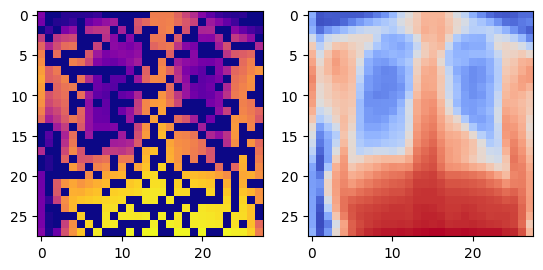

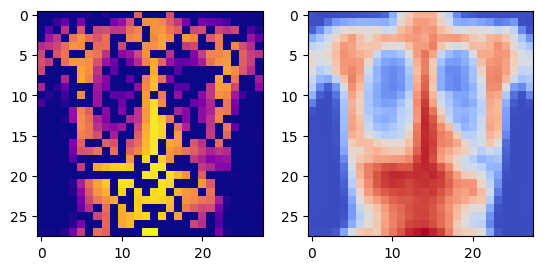

78468 11219
torch.Size([78468, 1, 28, 28])
tensor(0, dtype=torch.uint8) tensor(253, dtype=torch.uint8)


In [6]:
train_dataset = ChestMNIST("./chestmnist.npz", split="train")
valid_dataset = ChestMNIST("./chestmnist.npz", split="val")

fig, axs = plt.subplots(1, 2)
axs[0].imshow(train_dataset[0][0][0], cmap="plasma")
axs[1].imshow(train_dataset[0][1][0], cmap="coolwarm")
plt.show()

fig, axs = plt.subplots(1, 2)
axs[0].imshow(valid_dataset[0][0][0], cmap="plasma")
axs[1].imshow(valid_dataset[0][1][0], cmap="coolwarm")
plt.show()

print(len(train_dataset), len(valid_dataset))
print(train_dataset.data.shape)
print(train_dataset.data.min(), train_dataset.data.max())

### 2.4 Modify our ``simpleFFN`` model

* Add two more hidden layers to the model

* Change the size of the output to match the size of the input

* Change the activation of the model to [``Mish``](https://arxiv.org/abs/1908.08681)

* Change the activation of last layer, what should it be?

* Instantiate the model and print a summary


In [7]:
# 1
# Modify model
class simpleFFN(nn.Module):
  def __init__(self, input_size, hidden_size_1=200, hidden_size_2=100, hidden_size_3=100, hidden_size_4=200):
    super(simpleFFN, self).__init__()
    self.hidden_1 = nn.Linear(input_size, hidden_size_1, bias=False)
    self.hidden_2 = nn.Linear(hidden_size_1, hidden_size_2, bias=False)
    self.hidden_3 = nn.Linear(hidden_size_2, hidden_size_3, bias=False)
    self.hidden_4 = nn.Linear(hidden_size_3, hidden_size_4, bias=False)
    self.output = nn.Linear(hidden_size_4, input_size, bias=False)
    self.activation = nn.Mish()
    self.sigmoid = nn.Sigmoid()

  def forward(self, X):
    # Hidden Layers
    z1 = self.hidden_1(X.flatten(start_dim=1))
    a1 = self.activation(z1)
    z2 = self.hidden_2(a1)
    a2 = self.activation(z2)
    z3 = self.hidden_3(a2)
    a3 = self.activation(z3)
    z4 = self.hidden_4(a3)
    a4 = self.activation(z4)

    # Output
    z5 = self.output(a4)
    a5 = self.sigmoid(z5)
    return a5.view(X.shape)

In [8]:
# 1
# Instantiate and print summary
model = simpleFFN(input_size=1 * 28 * 28).to(device)
summ = summary(model=model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]         156,800
              Mish-2                  [-1, 200]               0
            Linear-3                  [-1, 100]          20,000
              Mish-4                  [-1, 100]               0
            Linear-5                  [-1, 100]          10,000
              Mish-6                  [-1, 100]               0
            Linear-7                  [-1, 200]          20,000
              Mish-8                  [-1, 200]               0
            Linear-9                  [-1, 784]         156,800
          Sigmoid-10                  [-1, 784]               0
Total params: 363,600
Trainable params: 363,600
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.39
Estimated T

### 2.5 Prepare parameters and hyperparameters for training

* Set your hyperparameters:
    - seed: 42
    - mask probability: 0.6 (this is a heavy damaged imputation problem! We are only keeping 60% of the information)
    - learning rate: 1e-2
    - weight decay = 1e-6 (applied in optimiser)
    - batch size: 128
    - number of epochs: 30


* Instantiate ``simpleFFN`` as our model with hidden sizes: 150, 50, 50, 150

* Instantiate ``Adam`` as the optimiser

* Instantiate ``MSELoss`` as a criterion

* Collect any list of transformations you think are appropriate for this problem

* Instantiate the training and validation dataset and create the dataloader for each

* Visualise an input and target batch using ``make_grid``

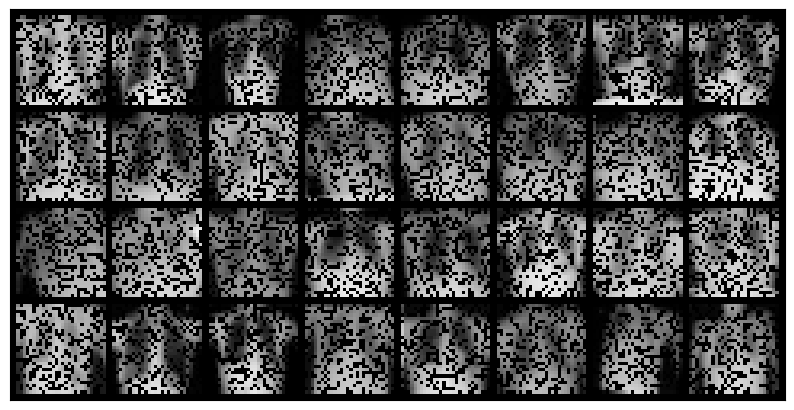

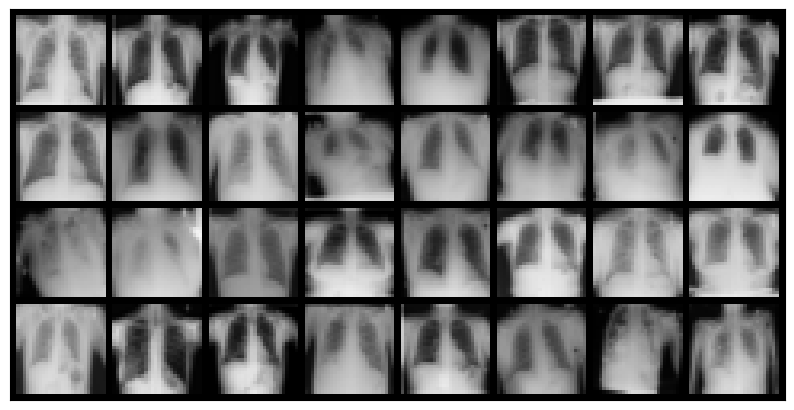

In [9]:
# 1
from torchvision.transforms import Compose, ToTensor, Lambda
from torch.utils.data import DataLoader
# Hyperparameters
set_seed(42)
p = 0.6
lr = 1e-2
wc = 1e-6
batch_size = 128
nepoch = 30


# Training set up: model, optimiser, criterion
model = simpleFFN(784, 150, 50, 50, 150).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wc)
criterion = nn.MSELoss()
# Transforms, Dataset and dataloader
transform = Compose([
    Lambda(lambda x: x / 255)
])


train_dataset = ChestMNIST(data_path="./chestmnist.npz", split="train", p=p, transform=transform)
validation_dataset = ChestMNIST(data_path="./chestmnist.npz", split="val", p=p, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, num_workers=0, shuffle=False)
# Visualise a batch sample
batch_sample = next(iter(train_loader))
input_grid = make_grid(batch_sample[0][:32])
target_grid = make_grid(batch_sample[1][:32])

plt.figure(figsize=(10,10))
plt.imshow(input_grid.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(target_grid.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.show()




### 2.6 Modify training and validation functions

* Make the necessary modifications to the ``train`` and ``valid`` functions from the lecture to adapt to our reconstruction problem

* Does prediction play a role in this problem?

* Is accuracy a suitable metric?


In [10]:
# Modify functions
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss= 0
    for input, target in data_loader:
        input, target = input.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output, target)
        loss.backward()

        train_loss += loss*input.size(0)
        # pred = output.softmax(dim=1).max(dim=1)[1]
        # train_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*input.size(0)

        optimizer.step()

    train_loss = train_loss / len(data_loader.dataset)
    #train_accuracy = train_accuracy/len(data_loader.dataset)
    return train_loss


def valid(model, criterion, data_loader):
    " Equivalent to the training function without any backpropagation or optimisation steps"
    model.eval()
    valid_loss =  0
    with torch.no_grad():
        for input, target in data_loader:
            input, target = input.to(device), target.to(device)

            output = model(input)
            loss = criterion(output, target)

            valid_loss += loss*input.size(0)

            # pred = output.softmax(dim=1).max(dim=1)[1]

            # valid_accuracy += accuracy_score(target.cpu().numpy(), pred.detach().cpu().numpy())*input.size(0)

        valid_loss = valid_loss / len(data_loader.dataset)
       # valid_accuracy = valid_accuracy/len(data_loader.dataset)
        return valid_loss


### 2.7 Train and validate the model

* Train your model

* Visualise the output of a validation sample along training

* At the end of training, plot the 32 reconstructed and target samples from a validation batch

* What do you observe?

* Are the results as expected?


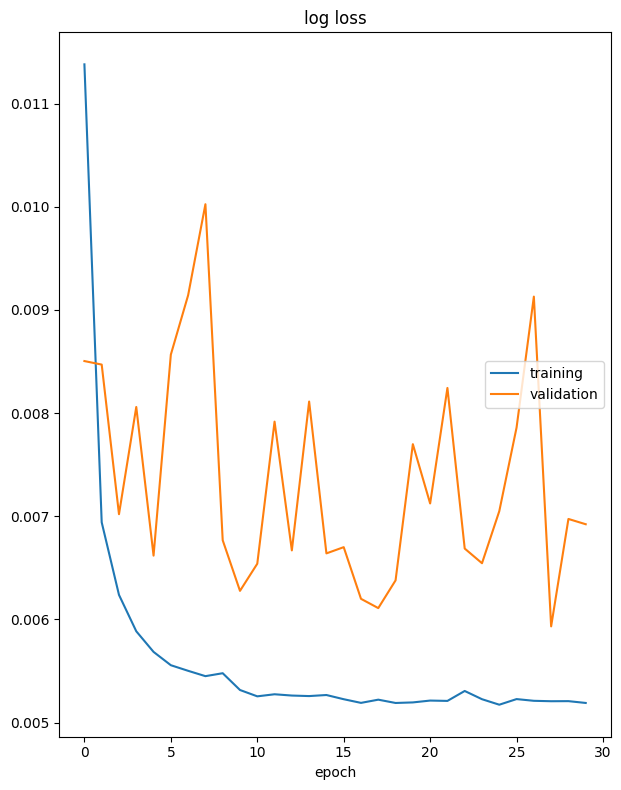

log loss
	training         	 (min:    0.005, max:    0.011, cur:    0.005)
	validation       	 (min:    0.006, max:    0.010, cur:    0.007)
0.006923291832208633


In [12]:
# Train model
liveloss = PlotLosses()    # plots evolution of loss and accuracy
for epoch in range(nepoch):
    logs = {}
    train_loss = train(model, optimiser, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    #logs['' + 'accuracy'] = train_accuracy.item()

    validation_loss = valid(model, criterion, validation_loader)
    logs['val_' + 'log loss'] = validation_loss.item()
    #logs['val_' + 'accuracy'] = validation_accuracy.item()

    liveloss.update(logs)
    liveloss.draw()
    print(validation_loss.item())


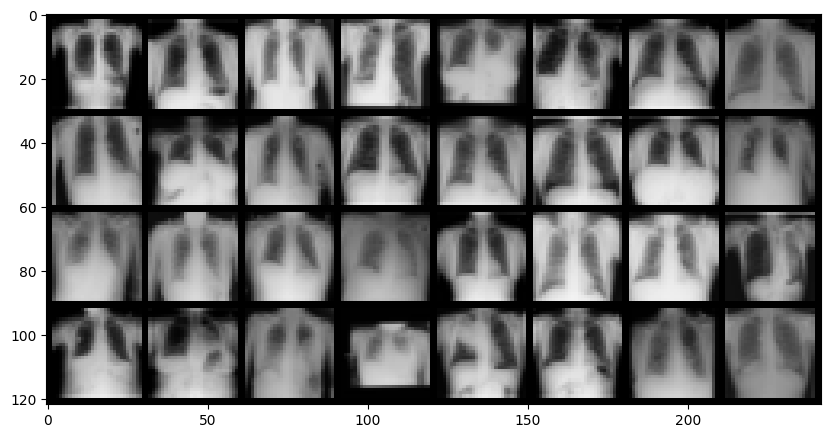

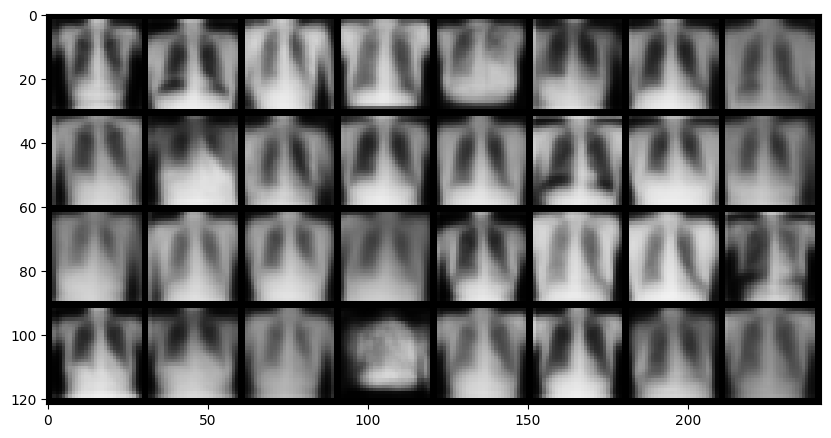

In [14]:
# 1
# Plot recon and target from valid batch
input, target = next(iter(validation_loader))
input, target = input[:32], target[:32]
output = model(input.to(device))

target_grid = make_grid(target)
output_grid = make_grid(output)

plt.figure(figsize=(10,10))
plt.imshow(target_grid.detach().cpu().permute(1,2,0))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(output_grid.detach().cpu().permute(1,2,0))
plt.show()

### 2.8 Save model to disk and load

* ``Pytorch`` stores all the parameters of models and optimizers, their weights and biases in an easy to read dictionary called a "state-dict".

* When we store models and optimizers, we store the state-dict.  

* Together with the model definition we can then restore the model to it's state when we stored it to disk.

* Let's look at the contents of the state-dict of both our optimizer and our model:

In [15]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimiser's state_dict
print("Optimiser's state_dict:")
for var_name in optimiser.state_dict():
    print(var_name, "\t", optimiser.state_dict()[var_name])


Model's state_dict:
hidden_1.weight 	 torch.Size([150, 784])
hidden_2.weight 	 torch.Size([50, 150])
hidden_3.weight 	 torch.Size([50, 50])
hidden_4.weight 	 torch.Size([150, 50])
output.weight 	 torch.Size([784, 150])
Optimiser's state_dict:
state 	 {0: {'step': tensor(18420.), 'exp_avg': tensor([[-4.6234e-09, -2.3301e-09, -2.4728e-09,  ...,  6.7680e-09,
          1.1671e-09, -1.0267e-09],
        [-4.7310e-09, -2.3848e-09, -2.5313e-09,  ...,  7.0348e-09,
          1.3244e-09, -9.8597e-10],
        [-2.9643e-07, -8.7103e-07,  5.7575e-07,  ..., -1.7252e-07,
          2.6788e-06,  1.1425e-06],
        ...,
        [ 6.9235e-07, -1.1795e-06, -1.1870e-06,  ..., -1.1547e-06,
         -4.8802e-06, -3.2168e-06],
        [ 2.4572e-06,  1.0216e-06,  1.1210e-06,  ...,  2.8749e-07,
         -9.3048e-07, -8.6889e-07],
        [-4.6122e-09, -2.3245e-09, -2.4668e-09,  ...,  6.7374e-09,
          1.1508e-09, -1.0321e-09]], device='cuda:0'), 'exp_avg_sq': tensor([[5.5524e-16, 4.5434e-16, 4.6324e-16, 

From colab (and locally) we can store models to disk using ```torch.save``` and passing both a models state_dict() and a path where to store it.

In [16]:
#!mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model in Google Drive

model_save_name = 'chestmnist_simpleFFN_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
path = F'./{model_save_name}'                               # use this to store locally (it will be erased once the colab session is over)
torch.save(model.state_dict(), path)

optimiser_save_name = 'chestmnist_simpleFFN_optimiser.pt'
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}"
path = F"./{optimiser_save_name}"
torch.save(model.state_dict(), path)

Finally, we can restore models from the saved ```state_dict```'s and do a number of things such as:
1. Use it as a checkpoint and continue training (given we stored the optimizer as well)
2. Make predictions from our model
3. Perform inspections of our model
4. Use our model in ensembles
5. ...

By default a loaded model is put into ```.train()``` mode. So be careful when using networks that behave different depending on training and test time e.g. dropout regularized networks or batch-normalized networks.

In [19]:
model_save_name = 'chestmnist_simpleFFN_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
path = F'./{model_save_name}'

model = simpleFFN(input_size= 1 * 28 * 28, hidden_size_1=150, hidden_size_2=50, hidden_size_3=50, hidden_size_4=150).to(device) ## creates an instance of the model
model.load_state_dict(torch.load(path)) ## loads the parameters of the model in path. state_dict is a dictionary object that maps each layer in the model to its trainable parameters (weights and biases).
model.eval()

valid_loss = valid(model, criterion, validation_loader)
print("Avg. Valid Loss: %1.3f" % valid_loss.item())

Avg. Valid Loss: 0.007


### 2.8 Training with Unet

* Instantiate a ``U-net`` using the snipped below.

* For now you do not need to understand what a ``U-net`` is or how it works. This will be explored later in the course.

* Print the summary of the model and have a look at what kind of layers it includes. Search for these layers in the ``Pytorch`` documentation to gain a general understanding of their operations.



In [20]:
from monai.networks.nets import UNet
set_seed(42)
model = UNet(spatial_dims=2, in_channels=1, out_channels=1, channels=(8, 8, 8), strides=(1, 1,), act="mish").to(device)
summ = summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
    InstanceNorm2d-2            [-1, 8, 28, 28]               0
           Dropout-3            [-1, 8, 28, 28]               0
              Mish-4            [-1, 8, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]             584
    InstanceNorm2d-6            [-1, 8, 28, 28]               0
           Dropout-7            [-1, 8, 28, 28]               0
              Mish-8            [-1, 8, 28, 28]               0
            Conv2d-9            [-1, 8, 28, 28]             584
   InstanceNorm2d-10            [-1, 8, 28, 28]               0
          Dropout-11            [-1, 8, 28, 28]               0
             Mish-12            [-1, 8, 28, 28]               0
   SkipConnection-13           [-1, 16, 28, 28]               0
  ConvTranspose2d-14            [-1, 8,

* Train the model with the same hyperparameters from before. Don't forget to re-initialise the optimiser with the correct model parameters

* As before, visualise some validation samples along training.

* Plot 32 reconstructed and target samples from the validation batch

* Save your final model

* What differences do you observe from training with a simple feed-forward network? Why do you think that is?

In [22]:
# Instantiate optimiser
optimiser = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wc)

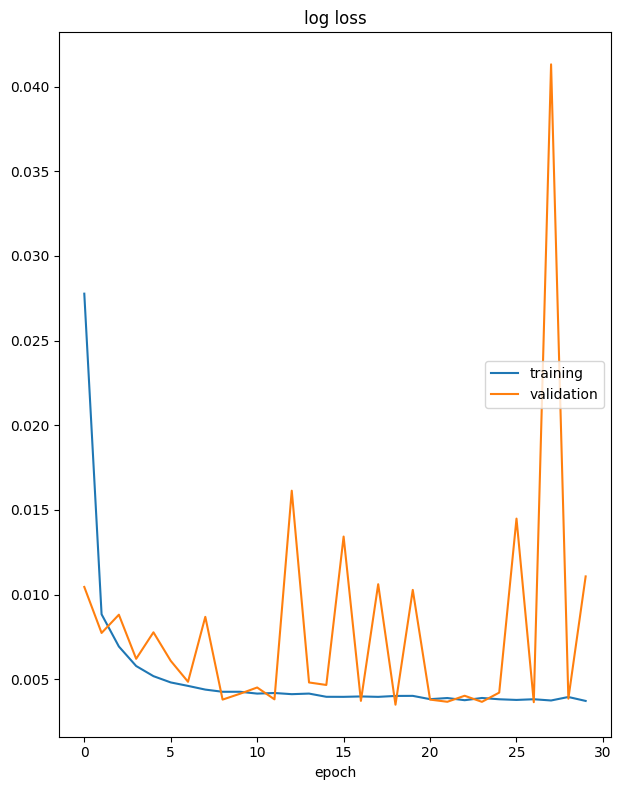

log loss
	training         	 (min:    0.004, max:    0.028, cur:    0.004)
	validation       	 (min:    0.003, max:    0.041, cur:    0.011)


In [25]:
# Train model
liveloss = PlotLosses()
for i in range(nepoch):
    train_loss = train(model, optimiser, criterion, train_loader)
    valid_loss = valid(model, criterion, validation_loader)

    # Liveloss plot
    logs = {}
    logs['' + 'log loss'] = train_loss.item()
    logs['val_' + 'log loss'] = valid_loss.item()
    liveloss.update(logs)
    liveloss.draw()

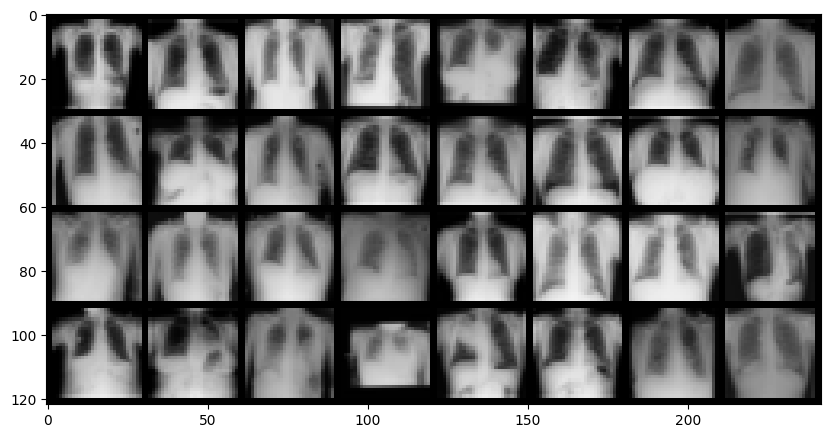

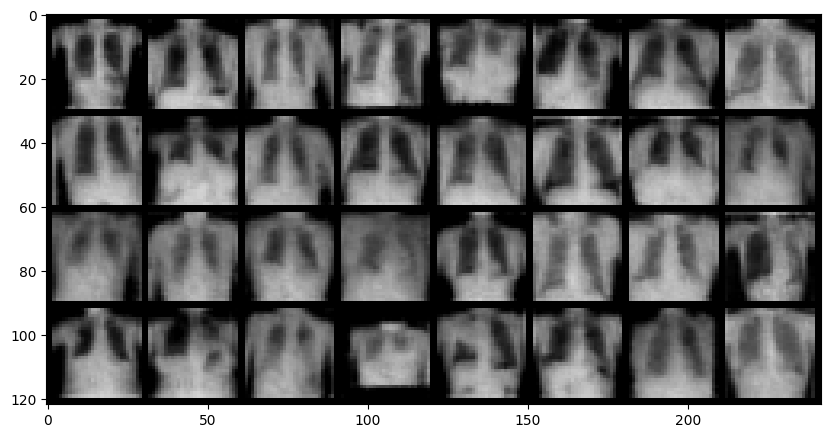

In [26]:
# Plot recon and target from valid batch
input, target = next(iter(validation_loader))
input, target = input[:32], target[:32]
output = model(input.to(device))

target_grid = make_grid(target)
output_grid = make_grid(output)

plt.figure(figsize=(10,10))
plt.imshow(target_grid.detach().cpu().permute(1,2,0))
plt.show()

plt.figure(figsize=(10,10))
plt.imshow(output_grid.detach().cpu().permute(1,2,0))
plt.show()

In [27]:
# 1
# Save model
# !mkdir '/content/gdrive/My Drive/models'  ## create the director for storing the model in Google Drive

model_save_name = 'chestmnist_Unet_model.pt'           # .pt and .pth are common file extensions for saving models in pytorch
path = F"/content/gdrive/My Drive/models/{model_save_name}" # use this to store in your Google Drive storage
path = F'./{model_save_name}'                               # use this to store locally (it will be erased once the colab session is over)
torch.save(model.state_dict(), path)

optimiser_save_name = 'chestmnist_Unet_optimiser.pt'
path = F"/content/gdrive/My Drive/models/{optimiser_save_name}"
path = F"./{optimiser_save_name}"
torch.save(model.state_dict(), path)